In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import distance
import numpy as np
import os

In [10]:
def read_df():
    """
    This function is reads the datataset_SCL.csv file and checks for any null 

    Parameters
    ---------------------------
    None

    Returns
    --------------------------

    df:pandas.DataFrame
        Dataframe containing the dataset corresponds to a flight that landed or took off from SCL during 2017.
    
    """
    
    df = pd.read_csv(os.path.join('..','data','raw','dataset_SCL.csv'),
        parse_dates=['Fecha-I','Fecha-O'])

    
    # NaN check in data frame
    if df.isnull().any().any():

        print('There is/are NaN in these Rows\n',df.isnull().any())

    return df


In [5]:
df = read_df()
df.head()

C:\Users\alan.matys\AppData\Local\Temp\ipykernel_29672\1541495544.py:17: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join('..','data','raw','dataset_SCL.csv'),


There is/are NaN in these Rows
 Fecha-I      False
Vlo-I        False
Ori-I        False
Des-I        False
Emp-I        False
Fecha-O      False
Vlo-O         True
Ori-O        False
Des-O        False
Emp-O        False
DIA          False
MES          False
AÑO          False
DIANOM       False
TIPOVUELO    False
OPERA        False
SIGLAORI     False
SIGLADES     False
dtype: bool


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [6]:
def synthetic_features(df):
    """
    This function's objective is to create the synthetic features required on the Challenge, including:

    
    - high_season: 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.

    - min_diff: difference in minutes between Date-O and Date-I .

    - delay_15: 1 if min_diff > 15, 0 if not.

    - period_day:morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based on Date-I.

    If the 'synthetic_features.csv' file already exists in data/interim, it concatenates both dfs 

    Parameters
    -------------------------
    df: pandas.DataFrame
        DataFrame corresponding to the Latam Challenge

    Returns
    -------------------------
    df: pandas.DataFrame
        Dataframe with the syntetic features added as columns
    
    """

    # Check if the synthetic_features file exists, concat and return concated df
    if os.path.exists(os.path.join('..','data','interim','synthetic_features.csv')):

        df_synt = pd.read_csv(os.path.join('..','data','interim','synthetic_features.csv'))

        df = pd.concat([df,df_synt], axis=1)
        
        return df

    # New columns to create
    new_cols = ['high_season','min_diff','delay_15','period_day']

    # Define high_season
    high_season = (
                (df['Fecha-I'].between('2016-12-15','2017-03-03')) 
                | (df['Fecha-I'].between('2017-09-11','2017-09-30')) 
                | (df['Fecha-I'].between('2017-07-15','2017-07-31'))
    )

    df[new_cols[0]] = np.where(high_season, 
                               1,
                               0)

    df[new_cols[1]] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds() / 60.0

    # Create the 
    df[new_cols[2]] = np.where(df['min_diff'] > 15,
                              1,
                              0)
    
    # Create a function to classify the time of the day
    def classify_time(time):
        if 5 <= time.hour <= 11:
            return 'morning'
        elif 12 <= time.hour <= 18:
            return 'afternoon'
        else:
            return 'night'

    # Create the period_day column with the previously defined funciton
    df[new_cols[3]] = df['Fecha-I'].apply(classify_time)

    
    df.loc[:,new_cols].to_csv(os.path.join('..','data','interim','synthetic_features.csv'), index=False)

    return df

In [348]:
df = synthetic_features(df)
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0,night


## EDA (Exploratory Data Analysis)

In this section we try to describe the categorical and the numerical variables

### Categorical Features

In [7]:
def programed_vs_operated(df:pd.DataFrame):
    """

    Plot the comparision of the Programed features vs the Operated features

    Parameters
    --------------------

    - df: pandas.DataFrame
        Pandas DataFrame containing the this columns:
        - Origin Variables (Ori-I/Ori-O)
        - Destination Variables (Des-I/Des-O)
    
    """
    fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,12))

    fig.suptitle('Programmed vs Operation')

    sns.countplot(x=df["Ori-I"],
                order = df['Ori-I'].value_counts().index,
                ax=axes[0,0],
                color='red',
                alpha=0.7)

    sns.countplot(x=df["Ori-O"],
                order = df['Ori-O'].value_counts().index,
                ax=axes[0,1],
                color='blue',
                alpha=0.7)

    sns.countplot(x=df["Des-I"],
                order = df['Des-I'].value_counts().index,
                ax=axes[1,0],
                color='red',
                alpha=0.7)
    axes[1,0].tick_params(axis='x', rotation=90)

    sns.countplot(x=df["Des-O"],
                order = df['Des-O'].value_counts().index,
                ax=axes[1,1],
                color='blue',
                alpha=0.7)
    axes[1,1].tick_params(axis='x', rotation=90)

    dis_des = len(df[df['Des-I'] != df['Des-O']])

    axes[1,1].text(.4, .70,
                    f'There are {dis_des} flights that ended on a different destination',
                    ha='left',
                    va='top',
                    color='blue',
                    transform=axes[1,1].transAxes)

    sns.countplot(x=df["Emp-I"],
                order = df['Emp-I'].value_counts().index,
                ax=axes[2,0],
                color='red',
                alpha=0.7)
    axes[2,0].tick_params(axis='x', rotation=90)

    sns.countplot(x=df["Emp-O"],
                order = df['Emp-O'].value_counts().index,
                ax=axes[2,1],
                color='blue',
                alpha=0.7)
    axes[2,1].tick_params(axis='x', rotation=90)

    dis_emp = len(df[df['Emp-I'] != df['Emp-O']])

    axes[2,1].text(.4, .70,
                    f'There are {dis_emp} flights that have a diifferent Airline Code',
                    ha='left',
                    va='top',
                    color='blue',
                    transform=axes[2,1].transAxes)

    plt.show()

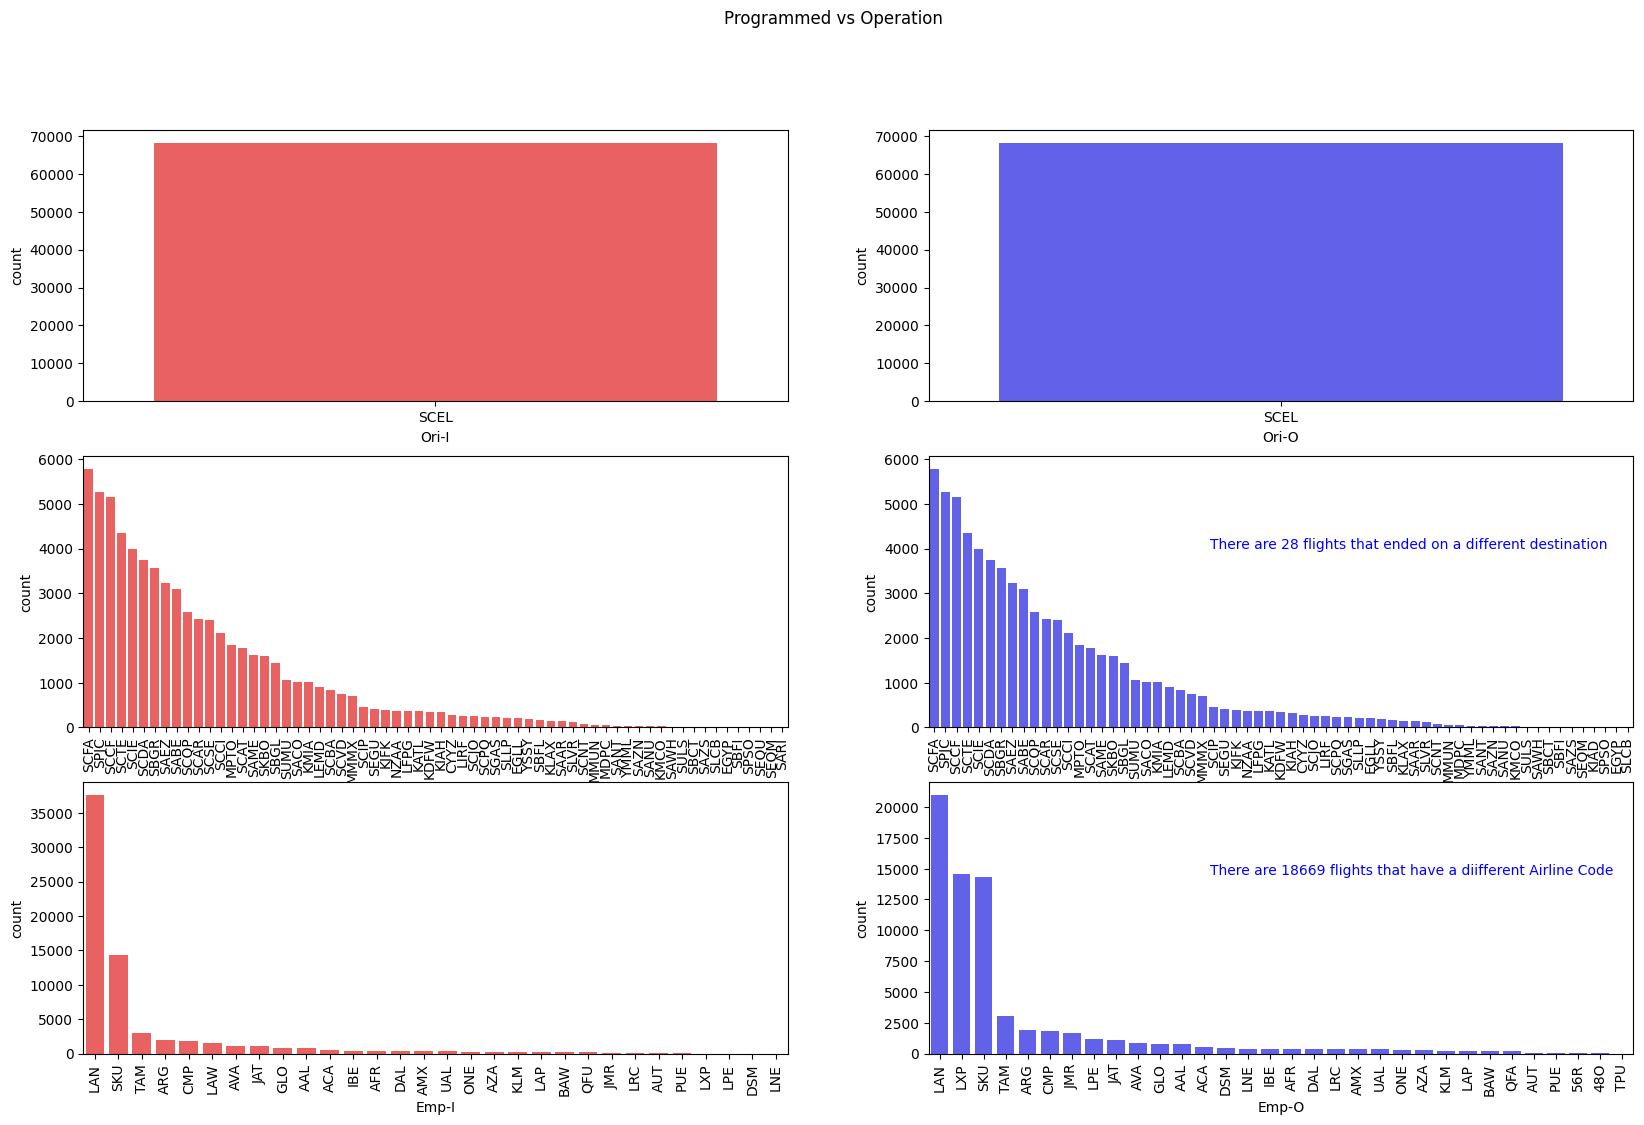

In [350]:
programed_vs_operated(df)

In [352]:
def other_categorical(df):
    """
    
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,4))

    sns.histplot(x=df["TIPOVUELO"],
                    multiple="dodge", 
                    stat = 'percent',
                    shrink = 0.8,
                    common_norm=False,
                    ax = axes[0,0])

    sns.histplot(x=df["DIANOM"],
                    multiple="dodge", 
                    stat = 'percent',
                    shrink = 0.8,
                    common_norm=False,
                    ax = axes[0,1],
                    discrete=True)

    sns.countplot(x=df['SIGLADES'],
                ax = axes[1,0],
                order = df['SIGLADES'].value_counts().index
                )

    axes[1,0].tick_params(axis='x', rotation=90)

    sns.histplot(x=df["OPERA"],
                    multiple="dodge", 
                    stat = 'percent',
                    shrink = 0.8,
                    ax = axes[1,1],
                    discrete=True)

    axes[1,1].tick_params(axis='x', rotation=90)


    plt.show()

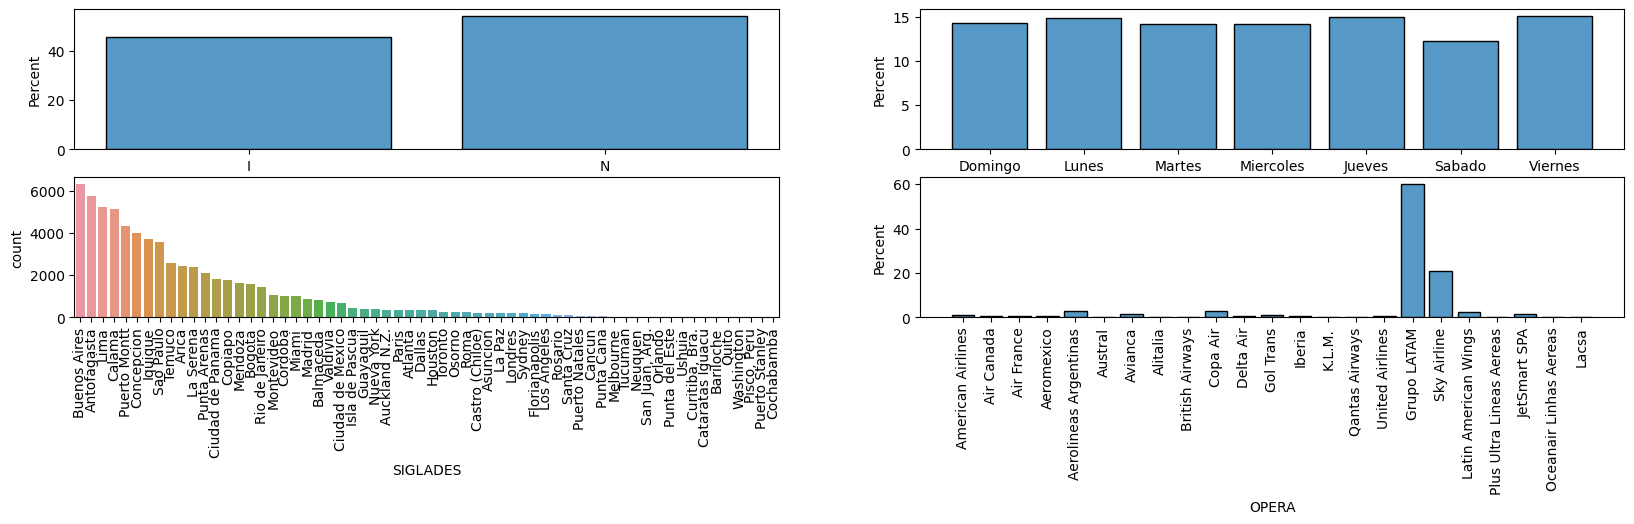

In [353]:
other_categorical(df)

## Continuous Features

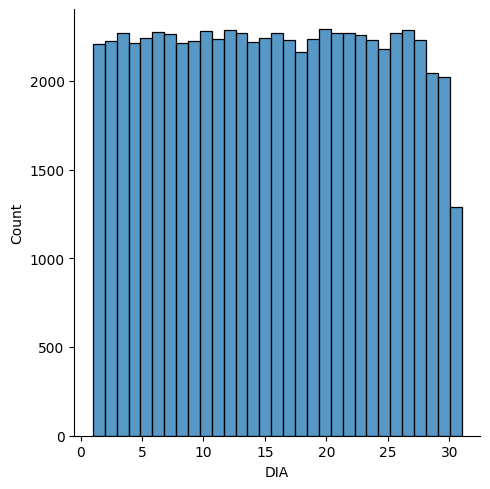

In [304]:
#fig, axes = plt.subplots(nrows=)

sns.displot(x=df['DIA'], bins=31)